# Deep Neural Networks Architectures: `LeNet`

### Loading Libraries

In [3]:
# Numerical Computing
import math
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization 
import matplotlib.pyplot as plt

# PyTorch
import torch
import torchaudio
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [4]:
torch.use_deterministic_algorithms(True)

### Placing `LeNet` Class()

1. Initialization and Architecture
2. Forward motion
3. Flatten feature and outcome

In [6]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training Set

In [10]:
def train(net, trainloader, optim, epoch):
    # Loss Initialization
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        ip, ground_truth = data

        # Zero's Parameter Gradients
        optim.zero_grad()

        # Forward Pass + Backward Pass + Optimization Step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # Loss updates
        loss_total += loss.item()
        
        # Print Loss Statistics
        if (i+1) % 1000 == 0:    
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

### Test Set

In [11]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

In [12]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)


# Ordering Relevancy
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|████████████████████████████████████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### `Image Display` Function()

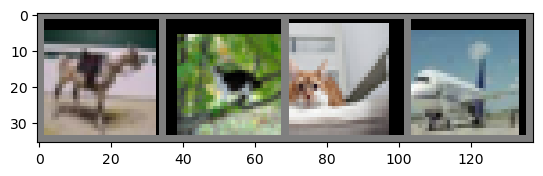

    horse  ||  cat  ||  cat  ||  plane


In [13]:
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# Sample Images from Training Set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display Images in a Grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [14]:
# Optimizer Definition
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

for epoch in range(50):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.752
[Epoch number : 1, Mini-batches:  2000] loss: 8.746
[Epoch number : 1, Mini-batches:  3000] loss: 8.197
[Epoch number : 1, Mini-batches:  4000] loss: 8.046
[Epoch number : 1, Mini-batches:  5000] loss: 7.789
[Epoch number : 1, Mini-batches:  6000] loss: 7.591

LeNet accuracy on 10000 images from test dataset: 48 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.411
[Epoch number : 2, Mini-batches:  2000] loss: 7.376
[Epoch number : 2, Mini-batches:  3000] loss: 7.236
[Epoch number : 2, Mini-batches:  4000] loss: 7.109
[Epoch number : 2, Mini-batches:  5000] loss: 6.959
[Epoch number : 2, Mini-batches:  6000] loss: 6.928

LeNet accuracy on 10000 images from test dataset: 54 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.869
[Epoch number : 3, Mini-batches:  2000] loss: 6.849
[Epoch number : 3, Mini-batches:  3000] loss: 6.701
[Epoch number : 3, Mini-batches:  4000] loss: 6.747
[Epoch number : 3, Mini-batches:  5000] loss: 6.616
[E

In [15]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

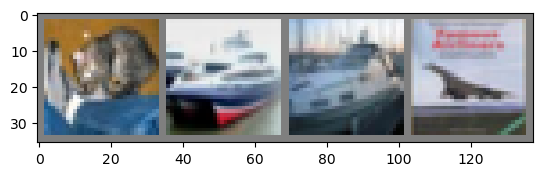

Label:         cat  ship  ship plane
Prediction:    cat  ship  ship plane


/var/folders/dk/f9pbhbp52qxc0613mpbtx8lm0000gn/T/ipykernel_56966/18595654.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_cached.load_state_dict(torch.load(model_

In [16]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [17]:
success = 0

counter = 0

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 66 %


In [18]:
class_sucess = list(0. for i in range(10))

class_counter = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 76 %
Model accuracy for class   car : 84 %
Model accuracy for class  bird : 70 %
Model accuracy for class   cat : 28 %
Model accuracy for class  deer : 58 %
Model accuracy for class   dog : 57 %
Model accuracy for class  frog : 71 %
Model accuracy for class horse : 64 %
Model accuracy for class  ship : 77 %
Model accuracy for class truck : 71 %
